In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tqdm

from tqdm import tqdm

build_data = False

class DogsvsCats():
    
    img_size = 50
    cats = '/Users/varun/documents/deep_learning/Learn_PYTORCH/PetImages/Cat'
    dogs = '/Users/varun/documents/deep_learning/Learn_PYTORCH/PetImages/Dog'
    labels = {cats:0,dogs:1}
    train_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):

        for label in self.labels:

            for f in tqdm(os.listdir(label)):
                    try:
                        path = os.path.join(label,f)
                        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img,(img_size,img_size))
                        ids = np.eye(2)[self.labels[label]]
                        train_data.append([np.array(img),ids])

                        if label == self.cats:
                                self.catcount +=1
                        else:
                                self.dogcount +=1
                    except Exception as e:
                        pass

            np.random.shuffle(train_data)
            np.save("train_data.npy",train_data)

            print(f"DOGS:  {self.dogcount}")
            print(f"CATS:  {self.catcount}")

if build_data:
    dogsvscats = DogsvsCats()
    dogsvscats.make_training_data()
else:
    train_data = np.load("train_data.npy",allow_pickle = True)

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F

training_data = train_data

class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 16, 3) 
        self.conv2 = nn.Conv2d(16, 32, 3) 
        self.conv3 = nn.Conv2d(32,64,3)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
       
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)


net = Net()
print(net)


import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1  
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

BATCH_SIZE = 100
EPOCHS = 3

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    

    print(f"Epoch: {epoch}. Loss: {loss}")

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


  0%|          | 0/228 [00:00<?, ?it/s]

2531


  0%|          | 1/228 [00:00<00:40,  5.64it/s]

Epoch: 0. Loss: 0.2124096006155014


  0%|          | 1/228 [00:00<00:42,  5.37it/s]

Epoch: 1. Loss: 0.1650785356760025


100%|██████████| 228/228 [00:43<00:00,  5.24it/s]

Epoch: 2. Loss: 0.14963680505752563


In [76]:
BATCH_SIZE = 100
EPOCHS = 7

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): 
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()   

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|          | 1/228 [00:00<00:41,  5.42it/s]

Epoch: 0. Loss: 0.14157035946846008


  0%|          | 1/228 [00:00<00:41,  5.44it/s]

Epoch: 1. Loss: 0.1289033442735672


  0%|          | 0/228 [00:00<?, ?it/s]

Epoch: 2. Loss: 0.11415434628725052


  0%|          | 0/228 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.10812649130821228


  0%|          | 1/228 [00:00<00:43,  5.20it/s]

Epoch: 4. Loss: 0.10172516852617264


  0%|          | 1/228 [00:00<00:39,  5.74it/s]

Epoch: 5. Loss: 0.09769976884126663


100%|██████████| 228/228 [00:43<00:00,  5.24it/s]

Epoch: 6. Loss: 0.09342584758996964


In [77]:
true = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            true += 1
        total += 1
print("Accuracy: ", round(true/total, 3)*100)

100%|██████████| 2531/2531 [00:03<00:00, 667.49it/s]

Accuracy:  78.5


In [78]:
BATCH_SIZE = 100
EPOCHS = 7

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): 
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()   

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|          | 0/228 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.08121996372938156


  0%|          | 1/228 [00:00<00:40,  5.55it/s]

Epoch: 1. Loss: 0.07651299983263016


  0%|          | 1/228 [00:00<00:41,  5.52it/s]

Epoch: 2. Loss: 0.07847309857606888


  0%|          | 1/228 [00:00<00:41,  5.49it/s]

Epoch: 3. Loss: 0.10728789120912552


  0%|          | 1/228 [00:00<00:38,  5.88it/s]

Epoch: 4. Loss: 0.10917562991380692


  0%|          | 1/228 [00:00<00:41,  5.42it/s]

Epoch: 5. Loss: 0.10071747750043869


100%|██████████| 228/228 [00:40<00:00,  5.58it/s]

Epoch: 6. Loss: 0.092434361577034


In [79]:
true = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            true += 1
        total += 1
print("Accuracy: ", round(true/total, 3)*100)

100%|██████████| 2531/2531 [00:03<00:00, 764.05it/s]

Accuracy:  76.3


In [80]:
BATCH_SIZE = 100
EPOCHS = 7

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): 
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()   

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|          | 1/228 [00:00<00:40,  5.63it/s]

Epoch: 0. Loss: 0.08382994681596756


  0%|          | 1/228 [00:00<00:41,  5.46it/s]

Epoch: 1. Loss: 0.07737281173467636


  0%|          | 1/228 [00:00<00:42,  5.40it/s]

Epoch: 2. Loss: 0.06402277946472168


  0%|          | 1/228 [00:00<00:42,  5.33it/s]

Epoch: 3. Loss: 0.05556550994515419


  0%|          | 1/228 [00:00<00:40,  5.56it/s]

Epoch: 4. Loss: 0.05551283061504364


  0%|          | 1/228 [00:00<00:41,  5.50it/s]

Epoch: 5. Loss: 0.050427284091711044


100%|██████████| 228/228 [00:41<00:00,  5.55it/s]

Epoch: 6. Loss: 0.05353087559342384


In [81]:
true = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            true += 1
        total += 1
print("Accuracy: ", round(true/total, 3)*100)

100%|██████████| 2531/2531 [00:03<00:00, 777.23it/s]

Accuracy:  76.1


tensor(1)


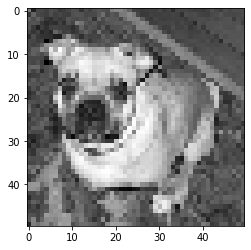

In [95]:
plt.imshow(X[0].view(50,50)*255,cmap='gray')
print(torch.argmax(net(X[0].view(-1,1,50,50))))

tensor(0)


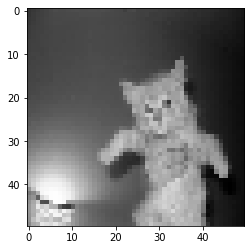

In [96]:
plt.imshow(X[1].view(50,50)*255,cmap = 'gray')
print(torch.argmax(net(X[1].view(-1,1,50,50))))

tensor(1)


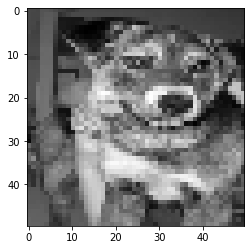

In [97]:
plt.imshow(X[2].view(50,50)*255,cmap = 'gray')
print(torch.argmax(net(X[2].view(-1,1,50,50))))

tensor(1)


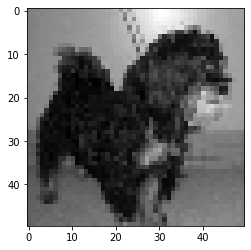

In [98]:
plt.imshow(X[3].view(50,50),cmap = 'gray')
print(torch.argmax(net(X[3].view(-1,1,50,50))))